In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 

from sklearn.metrics import roc_curve, auc

from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score
import sklearn.metrics as mt

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
 
df = pd.read_csv('../input/women-ecommerce/Womens Clothing E-Commerce Reviews.csv')
df = df[['Review Text','Rating','Class Name','Age']]
df1 = df
#df1.info()
#df1.describe()
df1.head()

,Review Text,Rating,Class Name,Age
0,Absolutely wonderful - silky and sexy and comf...,4,Intimates,33
1,Love this dress! it's sooo pretty. i happene...,5,Dresses,34
2,I had such high hopes for this dress and reall...,3,Dresses,60
3,"I love, love, love this jumpsuit. it's fun, fl...",5,Pants,50
4,This shirt is very flattering to all due to th...,5,Blouses,47


In [2]:
# fill NA values by space
df['Review Text'] = df['Review Text'].fillna('')

# CountVectorizer() converts a collection 
# of text documents to a matrix of token counts
vectorizer = CountVectorizer()
# assign a shorter name for the analyze
# which tokenizes the string
analyzer = vectorizer.build_analyzer()

def wordcounts(s):
    c = {}
    # tokenize the string and continue, if it is not empty
    if analyzer(s):
        d = {}
        # find counts of the vocabularies and transform to array 
        w = vectorizer.fit_transform([s]).toarray()
        # vocabulary and index (index of w)
        vc = vectorizer.vocabulary_
        # items() transforms the dictionary's (word, index) tuple pairs
        for k,v in vc.items():
            d[v]=k # d -> index:word 
        for index,i in enumerate(w[0]):
            c[d[index]] = i # c -> word:count
    return  c

# add new column to the dataframe
df['Word Counts'] = df['Review Text'].apply(wordcounts)
df.head()

,Review Text,Rating,Class Name,Age,Word Counts
0,Absolutely wonderful - silky and sexy and comf...,4,Intimates,33,"{'absolutely': 1, 'and': 2, 'comfortable': 1, ..."
1,Love this dress! it's sooo pretty. i happene...,5,Dresses,34,"{'am': 1, 'and': 2, 'bc': 2, 'be': 1, 'below':..."
2,I had such high hopes for this dress and reall...,3,Dresses,60,"{'and': 3, 'be': 1, 'bottom': 1, 'but': 2, 'ch..."
3,"I love, love, love this jumpsuit. it's fun, fl...",5,Pants,50,"{'and': 1, 'but': 1, 'compliments': 1, 'every'..."
4,This shirt is very flattering to all due to th...,5,Blouses,47,"{'adjustable': 1, 'all': 1, 'and': 1, 'any': 1..."


In [3]:
review_length = {'100':0,'200':0,'300':0,'400':0,'500':0,'600':0,'700':0}
for review in df['Review Text']:
    if len(review)<100:
        review_length['100'] +=1
    if 100<len(review)<200:
        review_length['200'] +=1
    if 200<len(review)<300:
        review_length['300'] +=1
    if 300<len(review)<400:
        review_length['400'] +=1
    if 400<len(review)<500:
        review_length['500'] +=1
    if 500<len(review)<600:
        review_length['600'] +=1
    if 600<len(review):
        review_length['700'] +=1
        


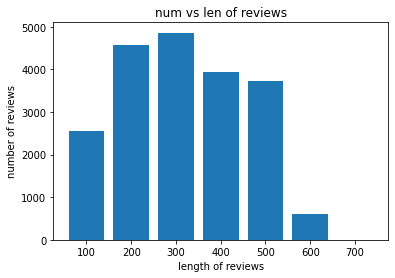

In [4]:
plt.xlabel('length of reviews')  
plt.ylabel('number of reviews')  
  

plt.title("num vs len of reviews")
plt.bar(*zip(*review_length.items()))
plt.show()

Selected Words
love     8951
great    6117
super    1726
happy     705
glad      614
dtype: int64

Class Names
Dresses     6319
Knits       4843
Blouses     3097
Sweaters    1428
Pants       1388
Name: Class Name, dtype: int64


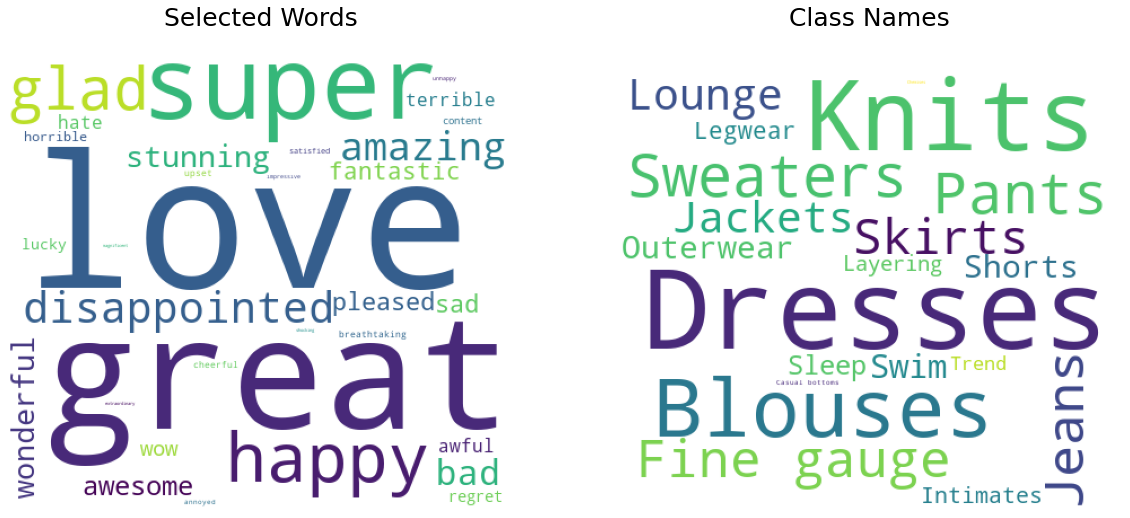

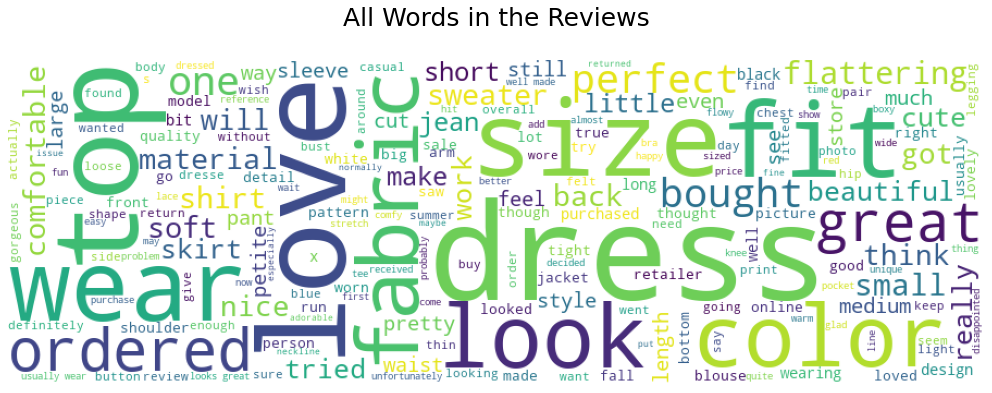

In [5]:
selectedwords = ['awesome','great','fantastic','extraordinary','amazing','super',
                 'magnificent','stunning','impressive','wonderful','breathtaking',
                 'love','content','pleased','happy','glad','satisfied','lucky',
                 'shocking','cheerful','wow','sad','unhappy','horrible','regret',
                 'bad','terrible','annoyed','disappointed','upset','awful','hate']

def selectedcount(dic,word):
    if word in dic:
        return dic[word]
    else:
        return 0
    
dfwc = df.copy()  
for word in selectedwords:
    dfwc[word] = dfwc['Word Counts'].apply(selectedcount,args=(word,))
    
word_sum = dfwc[selectedwords].sum()
print('Selected Words')
print(word_sum.sort_values(ascending=False).iloc[:5])

print('\nClass Names')
print(df['Class Name'].fillna("Empty").value_counts().iloc[:5])

fig, ax = plt.subplots(1,2,figsize=(20,10))
wc0 = WordCloud(background_color='white',
                      width=450,
                      height=400 ).generate_from_frequencies(word_sum)

cn = df['Class Name'].fillna(" ").value_counts()
wc1 = WordCloud(background_color='white',
                      width=450,
                      height=400 
                     ).generate_from_frequencies(cn)

ax[0].imshow(wc0)
ax[0].set_title('Selected Words\n',size=25)
ax[0].axis('off')

ax[1].imshow(wc1)
ax[1].set_title('Class Names\n',size=25)
ax[1].axis('off')

rt = df['Review Text']
plt.subplots(figsize=(18,6))
wordcloud = WordCloud(background_color='white',
                      width=900,
                      height=300
                     ).generate(" ".join(rt))
plt.imshow(wordcloud)
plt.title('All Words in the Reviews\n',size=25)
plt.axis('off')
plt.show()


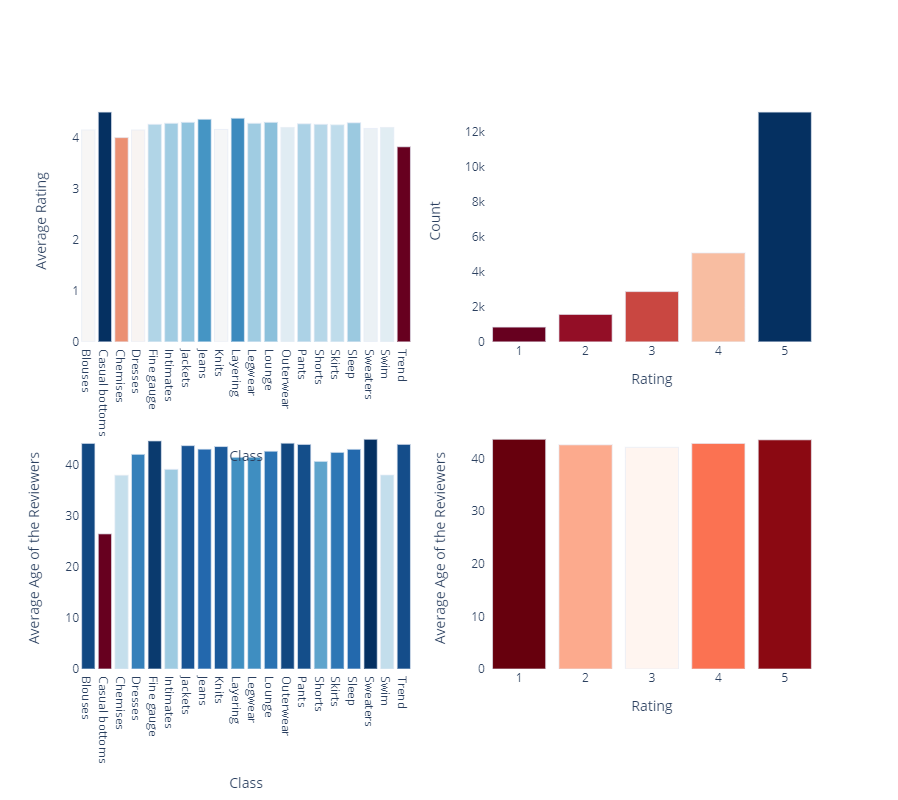

In [6]:
df1=df['Rating'].value_counts().to_frame()
avgdf1 = df.groupby('Class Name').agg({'Rating': np.average})
avgdf2 = df.groupby('Class Name').agg({'Age': np.average})
avgdf3 = df.groupby('Rating').agg({'Age': np.average})

trace1 = go.Bar(
    x=avgdf1.index,
    y=round(avgdf1['Rating'],2),
    marker=dict(
        color=avgdf1['Rating'],
        colorscale = 'RdBu')
)

trace2 = go.Bar(
    x=df1.index,
    y=df1.Rating,
    marker=dict(
        color=df1['Rating'],
        colorscale = 'RdBu')
)

trace3 = go.Bar(
    x=avgdf2.index,
    y=round(avgdf2['Age'],2),
    marker=dict(
        color=avgdf2['Age'],
        colorscale = 'RdBu')
)

trace4 = go.Bar(
    x=avgdf3.index,
    y=round(avgdf3['Age'],2),
    marker=dict(
        color=avgdf3['Age'],
        colorscale = 'Reds')
)

fig = tools.make_subplots(rows=2, cols=2, print_grid=False)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)

fig['layout']['xaxis1'].update(title='Class')
fig['layout']['yaxis1'].update(title='Average Rating')
fig['layout']['xaxis2'].update(title='Rating')
fig['layout']['yaxis2'].update(title='Count')
fig['layout']['xaxis3'].update(title='Class')
fig['layout']['yaxis3'].update(title='Average Age of the Reviewers')
fig['layout']['xaxis4'].update(title='Rating')
fig['layout']['yaxis4'].update(title='Average Age of the Reviewers')

fig['layout'].update(height=800, width=900,showlegend=False)
fig.update_layout({'plot_bgcolor':'rgba(0,0,0,0)',
                   'paper_bgcolor':'rgba(0,0,0,0)'})
#fig['layout'].update(plot_bgcolor='rgba(0,0,0,0)')
#fig['layout'].update(paper_bgcolor='rgba(0,0,0,0)')
py.iplot(fig)

It seems that most of the ratings are positive and the average rating between the classes looks close. On the other hand, when we look at ages, average age does not change significantly according to the rating. Also, average age changes slightly between class names except casual bottoms. We can disregard casual bottoms because the below chart shows that there are just two reviews and making an inference will not be right.

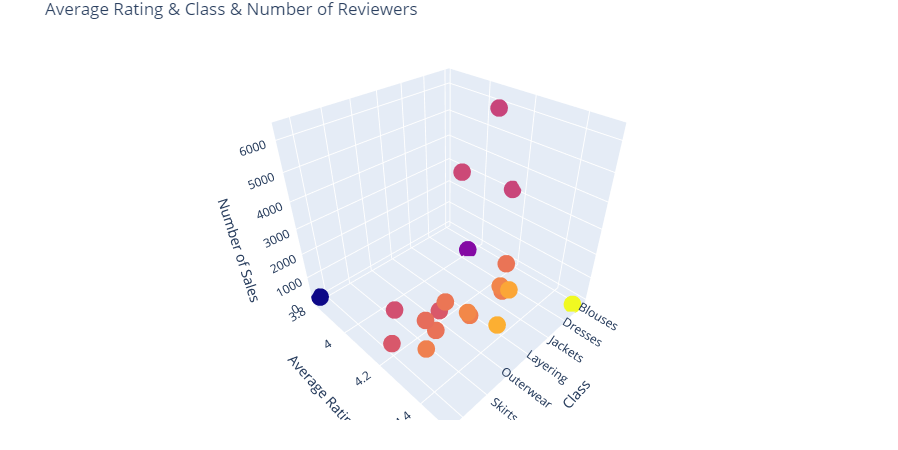

<Figure size 432x288 with 0 Axes>

In [7]:
cv = df['Class Name'].value_counts()

trace = go.Scatter3d( x = avgdf1.index,
                      y = avgdf1['Rating'],
                      z = cv[avgdf1.index],
                      mode = 'markers',
                      marker = dict(size=10,color=avgdf1['Rating']),
                      hoverinfo ="text",
                      text="Class: "+avgdf1.index+" \ Average Rating: "+avgdf1['Rating'].map(' {:,.2f}'.format).apply(str)+" \ Number of Reviewers: "+cv[avgdf1.index].apply(str)
                      )

data = [trace]
layout = go.Layout(title="Average Rating & Class & Number of Reviewers",
                   scene = dict(
                    xaxis = dict(title='Class'),
                    yaxis = dict(title='Average Rating'),
                    zaxis = dict(title='Number of Sales'),),
                   margin = dict(l=30, r=30, b=30, t=30))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)
plt.savefig('3D_Scatter.png')

In [8]:
# Rating of 3 -> neutral
df = df[df['Rating'] != 3]
df['Sentiment'] = df['Rating'] >=4
df.head()

# split data
train_data,test_data = train_test_split(df,train_size=0.8,random_state=0)
# select the columns and 
# prepare data for the models 
X_train = vectorizer.fit_transform(train_data['Review Text'])
y_train = train_data['Sentiment']
X_test = vectorizer.transform(test_data['Review Text'])
y_test = test_data['Sentiment']

# LOGISTIC REGRESSION

In [9]:
start=dt.datetime.now()
lr = LogisticRegression()
lr.fit(X_train,y_train)
print('Elapsed time : ',str(dt.datetime.now()-start))

Elapsed time :  0:00:01.059090


In [10]:
mt.recall_score(y_test,lr.predict(X_test))

0.9770804911323329

# HYPERPARAMETER OPTIMIZATION (LOGISTIC REGRESSION)

In [11]:
c_space = np.logspace(-5, 8, 15) 
param_grid = {'C': c_space} 
  
# Instantiating logistic regression classifier 
logreg = LogisticRegression() 
  
# Instantiating the GridSearchCV object 
logreg_cv = GridSearchCV(logreg, param_grid, cv = 5) 
  
logreg_cv.fit(X_train, y_train) 
  
# Print the tuned parameters and score 
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))  
print("Best score is {}".format(logreg_cv.best_score_)) 


Tuned Logistic Regression Parameters: {'C': 0.4393970560760795}
Best score is 0.9322696423250445


# DECISION TREE

In [12]:
start=dt.datetime.now()
dtr = DecisionTreeClassifier()
dtr.fit(X_train,y_train)
print('Elapsed time : ',str(dt.datetime.now()-start))

Elapsed time :  0:00:03.962219


# NAIVE BAYES

In [13]:
start=dt.datetime.now()
nb = MultinomialNB()
nb.fit(X_train,y_train)
print('Elapsed time: ',str(dt.datetime.now()-start))
print(mt.recall_score(y_test,nb.predict(X_test)))

Elapsed time:  0:00:00.008049
0.9778990450204639


In [14]:
param_grid_nb = {'alpha':[1.0,1.5,2.0,2.5],'fit_prior':[True,False]}
nb_cv = GridSearchCV(nb, param_grid_nb, cv = 5) 
nb_cv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [1.0, 1.5, 2.0, 2.5],
                         'fit_prior': [True, False]})

In [15]:
nb_cv.best_params_ #same as default

{'alpha': 1.0, 'fit_prior': True}

# RANDOM FOREST

In [16]:
from sklearn.metrics import f1_score,recall_score

In [17]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
print(mt.classification_report(y_test,rfc.predict(X_test)))
print(mt.recall_score(y_test,rfc.predict(X_test)))

              precision    recall  f1-score   support

       False       0.89      0.07      0.13       458
        True       0.90      1.00      0.94      3665

    accuracy                           0.90      4123
   macro avg       0.89      0.54      0.54      4123
weighted avg       0.90      0.90      0.85      4123

0.9989085948158254


# SVM

In [18]:
start=dt.datetime.now()
svm = SVC()
svm.fit(X_train,y_train)
print('Elapsed time: ',str(dt.datetime.now()-start))
print(f1_score(y_test,svm.predict(X_test)))

Elapsed time:  0:00:38.562273
0.961135429102003


# HYPERPARAMETER TUNING (SVM)

In [19]:
tuned_svm = SVC(C=10, gamma= 0.01, kernel= 'rbf')
tuned_svm.fit(X_train,y_train)

SVC(C=10, gamma=0.01)

# MULTI LAYER PERCEPTRON

In [20]:
start=dt.datetime.now()
nn = MLPClassifier()
nn.fit(X_train,y_train)
print('Elapsed time: ',str(dt.datetime.now()-start))

Elapsed time:  0:01:25.127147


# OPTIMIZATION OF MLP

In [21]:
mlp_gs = MLPClassifier(max_iter=100)
parameter_space = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=100), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(10, 30, 10), (20,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [22]:
print(mt.classification_report(y_test,clf.predict(X_test)))

              precision    recall  f1-score   support

       False       0.72      0.71      0.71       458
        True       0.96      0.97      0.96      3665

    accuracy                           0.94      4123
   macro avg       0.84      0.84      0.84      4123
weighted avg       0.94      0.94      0.94      4123



In [23]:
df2 = train_data.copy()
df2['Logistic Regression'] = lr.predict(X_train)
df2['Naive Bayes'] = nb.predict(X_train)
df2['SVM'] = svm.predict(X_train)
df2['Neural Network'] = nn.predict(X_train)

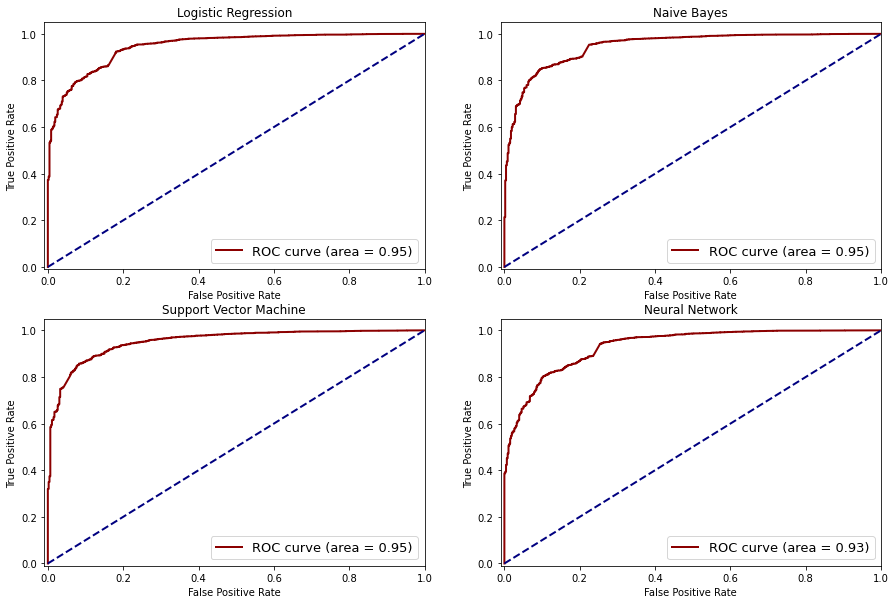

In [24]:
pred_lr = lr.predict_proba(X_test)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(y_test,pred_lr)
roc_auc_lr = auc(fpr_lr,tpr_lr)

pred_nb = nb.predict_proba(X_test)[:,1]
fpr_nb,tpr_nb,_ = roc_curve(y_test.values,pred_nb)
roc_auc_nb = auc(fpr_nb,tpr_nb)

pred_svm = svm.decision_function(X_test)
fpr_svm,tpr_svm,_ = roc_curve(y_test.values,pred_svm)
roc_auc_svm = auc(fpr_svm,tpr_svm)

pred_nn = nn.predict_proba(X_test)[:,1]
fpr_nn,tpr_nn,_ = roc_curve(y_test.values,pred_nn)
roc_auc_nn = auc(fpr_nn,tpr_nn)

f, axes = plt.subplots(2, 2,figsize=(15,10))
axes[0,0].plot(fpr_lr, tpr_lr, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_lr))
axes[0,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,0].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Logistic Regression')
axes[0,0].legend(loc='lower right', fontsize=13)

axes[0,1].plot(fpr_nb, tpr_nb, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_nb))
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,1].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Naive Bayes')
axes[0,1].legend(loc='lower right', fontsize=13)

axes[1,0].plot(fpr_svm, tpr_svm, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_svm))
axes[1,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,0].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Support Vector Machine')
axes[1,0].legend(loc='lower right', fontsize=13)

axes[1,1].plot(fpr_nn, tpr_nn, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_nn))
axes[1,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,1].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Neural Network')
axes[1,1].legend(loc='lower right', fontsize=13);

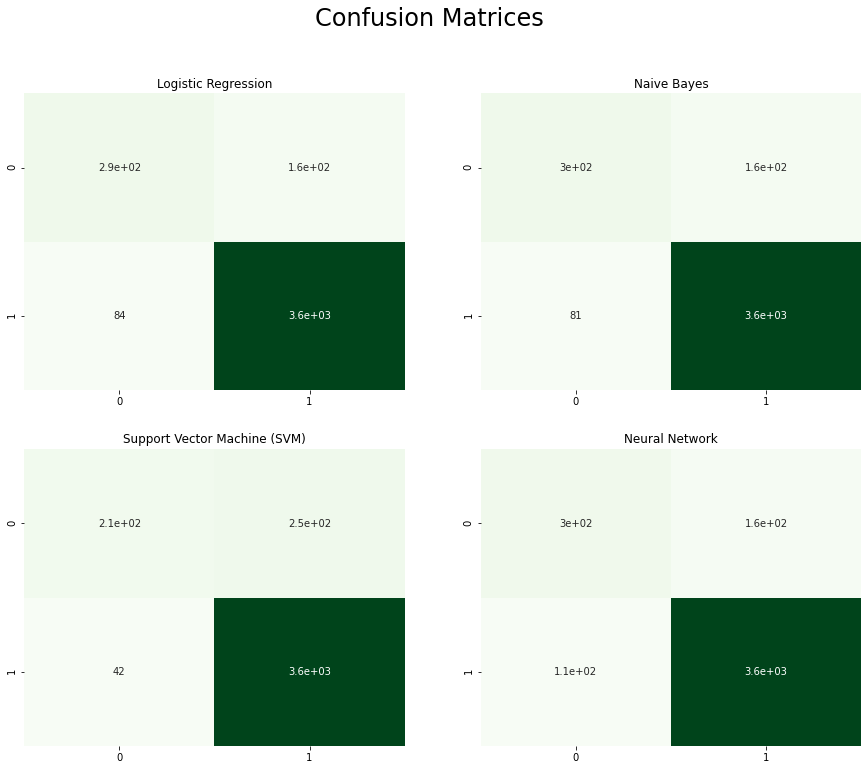

In [25]:
lr_cm=confusion_matrix(y_test.values, lr.predict(X_test))
nb_cm=confusion_matrix(y_test.values, nb.predict(X_test))
svm_cm=confusion_matrix(y_test.values, svm.predict(X_test))
nn_cm=confusion_matrix(y_test.values, nn.predict(X_test))

plt.figure(figsize=(15,12))
plt.suptitle("Confusion Matrices",fontsize=24)

plt.subplot(2,2,1)
plt.title("Logistic Regression")
sns.heatmap(lr_cm, annot = True, cmap="Greens",cbar=False);

plt.subplot(2,2,2)
plt.title("Naive Bayes")
sns.heatmap(nb_cm, annot = True, cmap="Greens",cbar=False);

plt.subplot(2,2,3)
plt.title("Support Vector Machine (SVM)")
sns.heatmap(svm_cm, annot = True, cmap="Greens",cbar=False);

plt.subplot(2,2,4)
plt.title("Neural Network")
sns.heatmap(nn_cm, annot = True, cmap="Greens",cbar=False);

## <span id="15"></span> Precision - Recall - F1-Score

In [26]:
print("Logistic Regression")
print(mt.classification_report(y_test, lr.predict(X_test)))
print("Tuned Logistic Regression")
print(mt.classification_report(y_test, logreg_cv.predict(X_test)))
print("\n Naive Bayes")
print(mt.classification_report(y_test, nb.predict(X_test)))
print("\n Support Vector Machine (SVM)")
print(mt.classification_report(y_test, svm.predict(X_test)))
print("\n Optimized svm")
print(mt.classification_report(y_test, tuned_svm.predict(X_test)))
print("\n Neural Network")
print(mt.classification_report(y_test, nn.predict(X_test)))
print("\n Decision Tree")
print(mt.classification_report(y_test, dtr.predict(X_test)))

Logistic Regression
              precision    recall  f1-score   support

       False       0.78      0.64      0.70       458
        True       0.96      0.98      0.97      3665

    accuracy                           0.94      4123
   macro avg       0.87      0.81      0.83      4123
weighted avg       0.94      0.94      0.94      4123

Tuned Logistic Regression
              precision    recall  f1-score   support

       False       0.79      0.64      0.70       458
        True       0.96      0.98      0.97      3665

    accuracy                           0.94      4123
   macro avg       0.87      0.81      0.84      4123
weighted avg       0.94      0.94      0.94      4123


 Naive Bayes
              precision    recall  f1-score   support

       False       0.79      0.65      0.71       458
        True       0.96      0.98      0.97      3665

    accuracy                           0.94      4123
   macro avg       0.87      0.82      0.84      4123
weighted avg  